In [1]:
import numpy as np
from matplotlib.pyplot import figure, show
from glm_utils import simpleaxis 

class SimpleIF(object):
    ''' Simple Integrated-and-fire model of the form:
        Cm*dV/dt + gl*(V-El) = Iapp

        Cm is the membrane capacitante
        gl is the leak conductance
        El is the resting membrane potential
        Ipp is the applied current
    '''

    def __init__(self, Cm, gl, El, Vinit=-70.):
        self._Cm = float(Cm) # in ms
        self._gl = float(gl) # in uS
        self._El = float(El) # in mV
        self._Vinit = float(Vinit) # in mV

        # fixed threshold
        self._Vthr = -49 # in mV

    def dVdt(self, Vmb, Iapp):
        ''' returns the instantaneous voltage change
            as a function of Cm, gl, El and Iapp
        '''
        Cm = self._Cm
        gl = self._gl
        El = self._El

        return (Iapp - gl*(Vmb - El) )/Cm

    def timecourse(self, current, noise_std = 0):
        ''' returns the time course of the voltage as
        a function of the current injected when solved
        by the implicit Euler method:
        f(x) = f(x-1) + dt*f'(x)

        we assume dt is the sampling interval of the current
        '''

        voltage = np.empty(len(current))

        # initial condition
        voltage[0] = self._Vinit
        dt = 0.05 # step size integration

        # Eulers solver
        for i in range(1, len(current)):
            dVdt = self.dVdt(Vmb = voltage[i-1], Iapp = current[i-1])
            voltage[i] = voltage[i-1] + dt*dVdt + np.random.normal(scale = noise_std)
            # action potential threshold
            if voltage[i] > self._Vthr:
                voltage[i-1] = 0.0 # overshooting
                voltage[i] = self._El # reset voltage

        return voltage

In [2]:
# current injection

#current = int(250/dt)*[0] + int(1000/dt)*[2.5] + int(250/dt)*[0]

from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

n_steps = 1e6
dt = 0.05 # in ms

time = np.linspace(0, int(n_steps*(dt/1000)), int(n_steps)) # transform in sec

num_objects = 15

stim_pres = 300 #ms
stim_step = 300

In [3]:
gain_factors = np.linspace(.5, 2, num = 10)

current_dict = {}
av_currents = []
for g_f in gain_factors:
    tuning = g_f*num_objects * norm.pdf(range(num_objects), loc = num_objects / 2, scale = 2)

    av_currents.append(np.max(tuning))
    
#plt.plot(current)
#plt.show()

#plt.plot(obj)

In [4]:
def calculate_rate(spikes, half_width):
    half_width = int(half_width)
    new_spikes = np.zeros_like(spikes)
    
    for i, s in enumerate(spikes):
        if i < half_width:
            first_half = np.zeros([half_width])
        else:
            first_half = spikes[i-half_width:i]
            
        if (len(spikes) - i) < half_width:
            second_half = np.zeros([half_width])
            
        else:
            second_half = spikes[i:i +half_width]
            
        new_spikes[i] = np.mean(np.sum([first_half, second_half]))
        
    return new_spikes

In [5]:
def calculate_variance(voltage):
    
    for i, v in enumerate(voltage):
        if v > -49:
            voltage[i - 100:i + 1000] = np.nan
            
    return np.nanvar(voltage)

In [8]:
250/dt

5000.0

In [7]:
figure_shit_out_re = []

reliability_re = []
reliability_std = []

rate_re = []
mean_var_re = []
marginal_var_re = []

gain_factors = np.linspace(.5, 2, num = 10)

noise_std = np.linspace(.01, 1, num = 10)

#noise = [.235, .34]
mem = [68, 70]

bootstraps =  10

for j, n in enumerate(noise_std):
    for g_f in gain_factors:
        rel = []
        ra = []
        mev = []
        mav = []
        for i in range(bootstraps):
            tuning = g_f*num_objects * norm.pdf(range(num_objects), loc = num_objects / 2, scale = 2)
            current = []
            obj = []

            #stim_pres = 300 #ms
            stim_step = 300

            item = np.random.randint(0, num_objects)
            for t in time * 1000:
                if t < stim_step:        
                    obj.append(item)
                    current.append(tuning[item])
                else:
                    stim_step += stim_pres
                    item = np.random.randint(0, num_objects)
                    obj.append(item)
                    current.append(tuning[item])

            #mycell = SimpleIF(Cm =4.9, gl = .16, El=-mem[j], Vinit = -mem[j]) # spike threshold = -50 mV!!!
            mycell = SimpleIF(Cm =4.9, gl = .16, El=-mem[0], Vinit = -mem[0])
            voltage = mycell.timecourse(current, noise_std = n)

            spikes = (voltage > -49).astype('int')
            rate = calculate_rate(spikes, 250/dt)

            spike_count = np.zeros([num_objects])
            num_pres = np.zeros([num_objects])

            for i in range(int(n_steps)):
                spike_count[obj[i]] += rate[i]
                num_pres[obj[i]] += 1

            spike_count = np.array(spike_count)
            num_pres = np.array(num_pres) / (float(stim_pres) / dt)

            spike_count /= num_pres

            spike_count /= 10000
            
            rel.append(np.var(spike_count) / np.var(rate))
            ra.append(np.mean(rate))
            mev.append(np.var(spike_count))
            mav.append(np.var(rate))

        reliability_re.append(np.mean(rel))
        reliability_std.append(np.std(rel)/ np.sqrt(10))
        rate_re.append(np.mean(rate))
        mean_var_re.append(np.mean(mev))
        marginal_var_re.append(np.mean(mav))
        figure_shit_out_re.append((n, g_f))

C:\Users\Amy\anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
reliability_re = np.array(reliability_re).reshape(10, 10)
reliability_std = np.array(reliability_std).reshape(10, 10)
rate_re = np.array(rate_re).reshape(10, 10)

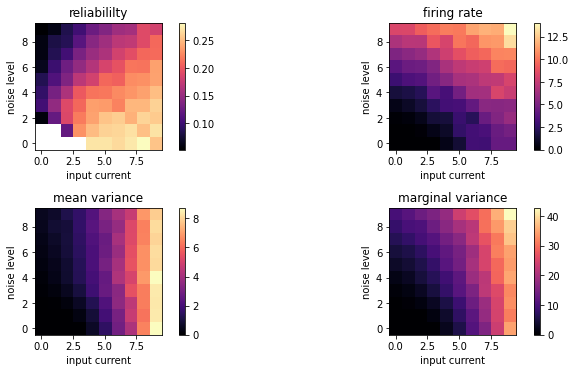

In [12]:
plt.figure(figsize = [10, 10])

plt.subplot(421)
plt.title('reliabililty')
plt.imshow(reliability_re, interpolation = 'none', cmap =  'magma', origin = 'lower')
plt.ylabel('noise level')
plt.xlabel('input current')
plt.colorbar()
plt.subplot(422)
plt.imshow(rate_re, interpolation = 'none', cmap = 'magma', origin = 'lower')
plt.title('firing rate')
plt.ylabel('noise level')
plt.xlabel('input current')
plt.colorbar()
plt.subplot(423)
plt.title('mean variance')
plt.imshow(np.array(mean_var_re).reshape(10, 10), interpolation = 'none', cmap = 'magma', origin = 'lower')
plt.ylabel('noise level')
plt.xlabel('input current')
plt.colorbar()
plt.subplot(424)
plt.title('marginal variance')
plt.imshow(np.array(marginal_var_re).reshape(10, 10), interpolation = 'none', cmap = 'magma', origin = 'lower')
plt.ylabel('noise level')
plt.xlabel('input current')
plt.colorbar()
plt.tight_layout()

#plt.savefig('./figs/final_figs/fig3supp/abc.eps', format='eps', dpi = 300);

(0.12, 0.26)

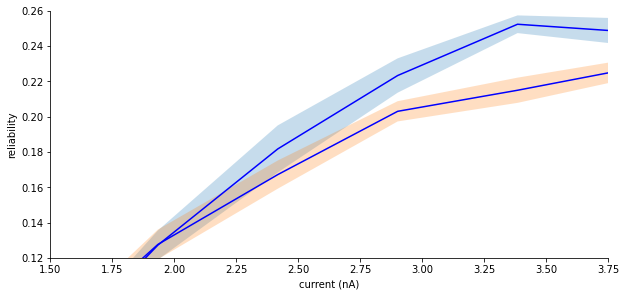

In [14]:
from glm_utils import simpleaxis

plt.figure(figsize = [10, 10])

reliability = np.array(mean_var_re) / np.array(marginal_var_re)

ax = plt.subplot(211)
for i in range(2):

    plt.plot(av_currents, reliability_re[i, :], c = 'b', alpha = 1);
    plt.fill_between(av_currents, reliability_re[i, :] - reliability_std[i, :], 
                     reliability_re[i, :] + reliability_std[i, :], alpha = .25)
    
simpleaxis(ax)
plt.ylabel('reliability')
plt.xlabel('current (nA)')
plt.xlim([1.5, 3.75])
plt.ylim([.12, .26])

#plt.savefig('./final_submission/figs/run_stat_LIF.eps', format='eps', dpi = 300);

In [ ]:
import pandas as pd

reliability_df = pd.DataFrame.from_dict({'current': av_currents, 'run_reliability': reliability_re[0, :], 'stat_reliability': reliability_re[1, :]})

In [ ]:
reliability_df.to_csv('figure4_run_stat_variance_voltage.csv', ',')

In [ ]:
current = int(10000/dt)*[0]  + int(500/dt)*[3.5] + int(500/dt)*[0]

var_ = []
var_std = []

#noise = [.235]#, .35]
noise = [.34]


for n in noise:
    v = []
    for i in range(bootstraps):
        mycell = SimpleIF(Cm =4.9, gl = .16, El=-70.1, Vinit = -70.1) # spike threshold = -49 mV!!!
        voltage = mycell.timecourse(current, noise_std = n)
        var = calculate_variance(voltage)
        v.append(var)
        
    var_.append(np.mean(v))
    var_std.append(np.std(v))

In [ ]:
var_

In [ ]:
current = int(1000/dt)*[0]  + int(500/dt)*[3.5] + int(1000/dt)*[0]
mycell = SimpleIF(Cm =4.9, gl = .16, El=-70., Vinit = -70.) # spike threshold = -49 mV!!!
voltage = mycell.timecourse(current, noise_std = .34)

In [ ]:
plt.figure(figsize = [10, 10])

ax  = plt.subplot(221)
plt.plot(voltage)
plt.plot(current)
plt.ylim([-90, 10])
simpleaxis(ax)

ax  = plt.subplot(222)
plt.plot(voltage1)
plt.plot(current)
plt.ylim([-90, 10])
simpleaxis(ax)

plt.savefig('./final_submission/figs/LIF_step.eps', format='eps', dpi = 300);